# Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, log_loss,get_scorer_names
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize

In [4]:
d2=pd.read_csv("Data_set_200_280.csv")

In [5]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [6]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


En este caso Sano:1 crepitante:0 y silibante:2

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna

In [7]:
for i in d2.columns.values[1:]:
    d2[i]=d2[i]/np.max(d2[i])

In [8]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,1,0.000354,0.000049,0.000325
1,1,0.000416,0.000029,0.000369
2,1,0.000388,0.000031,0.000362
3,1,0.000354,0.000027,0.000315
4,1,0.000319,0.000032,0.000276
...,...,...,...,...
4914,2,0.006475,0.001218,0.005667
4915,2,0.006143,0.000920,0.005367
4916,2,0.000716,0.000078,0.000624
4917,2,0.000630,0.000047,0.000523


Ahora revisemos la correlación con nuestro target de predicción que seria el estado

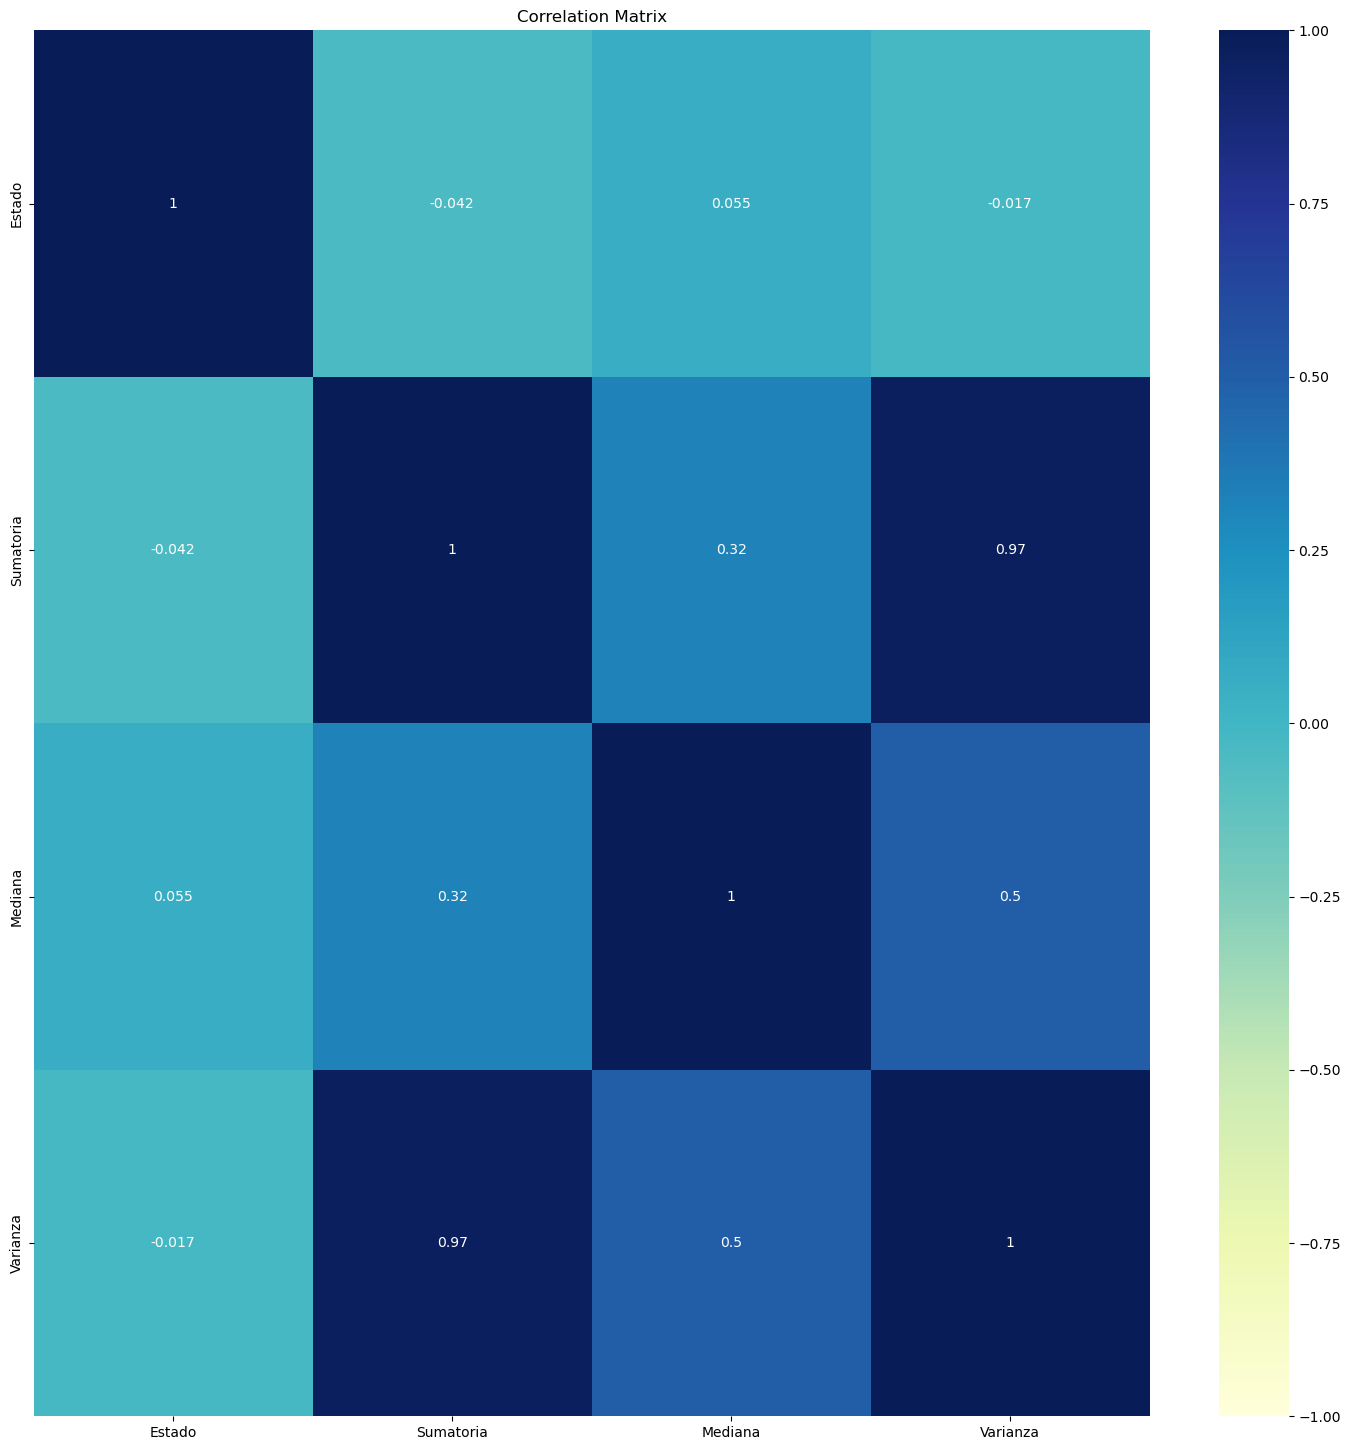

In [9]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [10]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

,Estado
Estado,1.000000
Mediana,0.054825
Varianza,-0.016609
Sumatoria,-0.042180


En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

# 1. Ciclos normales y ciclos crepitantes

## Entrenamiento

In [11]:
con=(d2.Estado.values==1)|(d2.Estado.values==0)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)

(4264, 3) (4264,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2984, 3) (1280, 3)


In [12]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def tuple_generator(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [14]:
def optimizador(Xtv,ytv,Xts,yts,start=1,end=20):
    best=0
    best_a=0
    def tuple_generator1(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)
    iter=list(tuple_generator1(start,end))
    for n in iter:
        mlp_relu = MLPClassifier(hidden_layer_sizes=n, activation='relu', solver='adam', max_iter=10000) 
        mlp_identity = MLPClassifier(hidden_layer_sizes=n, activation='identity', solver='adam', max_iter=10000) 
        mlp_tanh = MLPClassifier(hidden_layer_sizes=n, activation='tanh', solver='adam', max_iter=10000)
        mlp_logic=MLPClassifier(hidden_layer_sizes=n, activation='logistic', solver='adam', max_iter=10000)
        a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
        for n in a:
            n.fit(Xtv,ytv)
            acc=accuracy_score(yts,n.predict(Xts))
            if best_a<acc:
                best_a=acc
                best=n
    return best
        

In [15]:
def metrics(a,Xtv,ytv,Xts,yts,target_names):
    a.fit(Xtv,ytv)
    predict_train = a.predict(Xtv)
    predict_test = a.predict(Xts)
    print("Train ",a.activation)
    print("------------")
    print(classification_report(ytv,predict_train))
    mc_train = confusion_matrix(ytv,predict_train)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train '+a.activation)
    print("------------")
    print("Test ",a.activation)
    print(classification_report(yts,predict_test))
    mc_train = confusion_matrix(yts,predict_test)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test '+a.activation)

In [16]:
def tuple_generator(start, end):
    return list(itertools.product(range(start, end+ 1), repeat=3))

In [19]:
def me_da_pereza(i,Xtv,ytv,Xts,yts,target_names):
    for a in i:
        metrics(a,Xtv,ytv,Xts,yts,target_names)

## Funciones de perdida para optimización

- Para problemas binarios usar Binary Cross-Entropy, para multicategoricos usar Categorical Cross-Entropy (CCE)

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario, esto cambiara la forma del sigmoide, en el proceso se ira permutando los valores hasta encontrar un modelo más adecuado para la predicción 

## Resultados

## Lo que si se pidió

Train  relu
------------
Square error: 0.19600173837461973
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  relu
Square error: 0.2066869300911854
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
Square error: 0.19600173837461973
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  identity
Square error: 0.2066869300911854
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
Square error: 0.19600173837461973
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  tanh
Square error: 0.2066869300911854
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
Square error: 0.19600173837461973
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  logistic
Square error: 0.2066869300911854
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

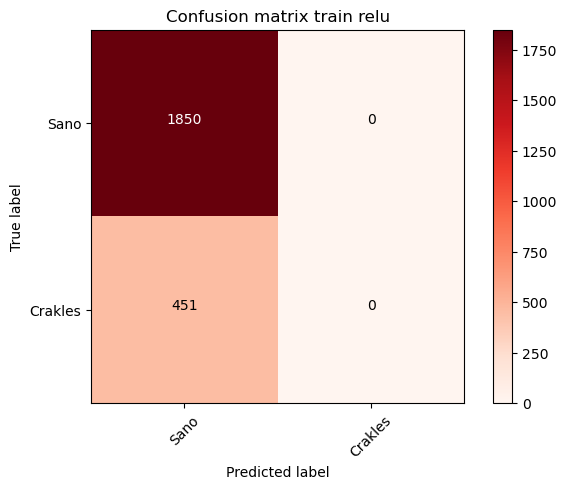

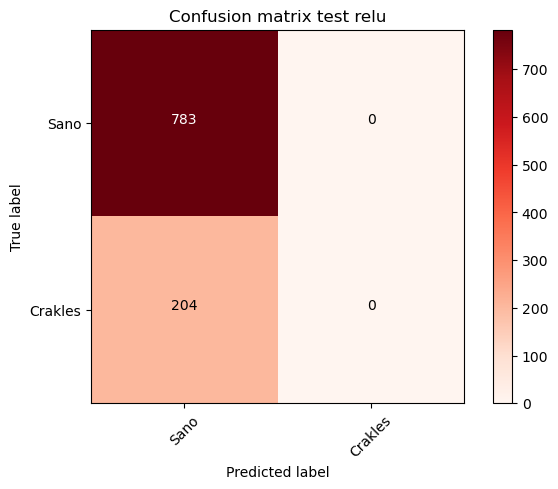

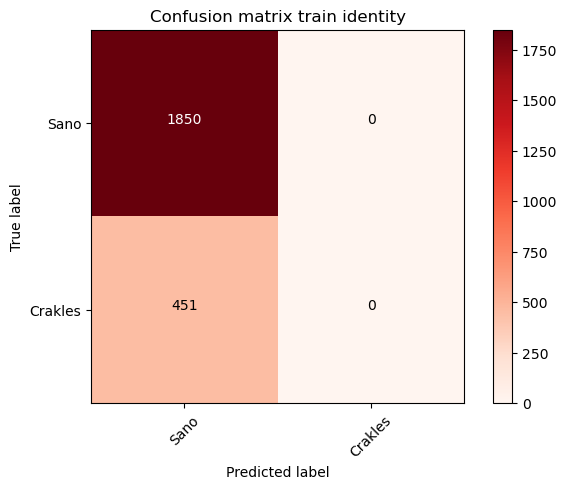

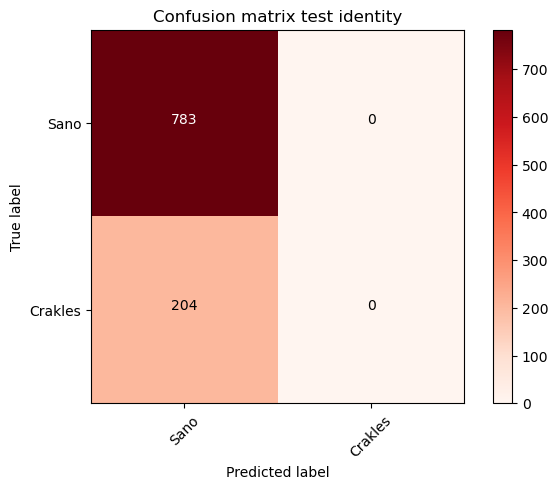

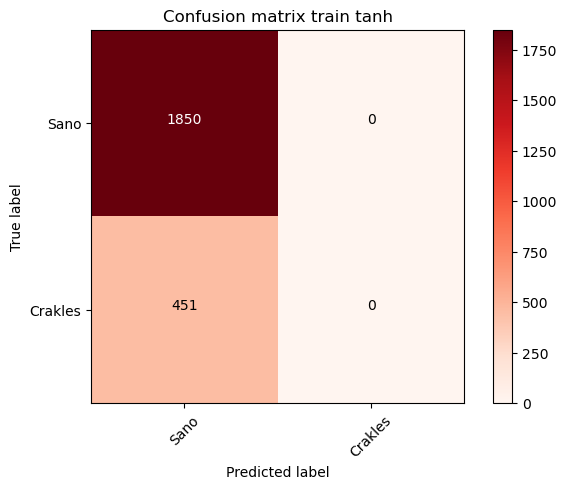

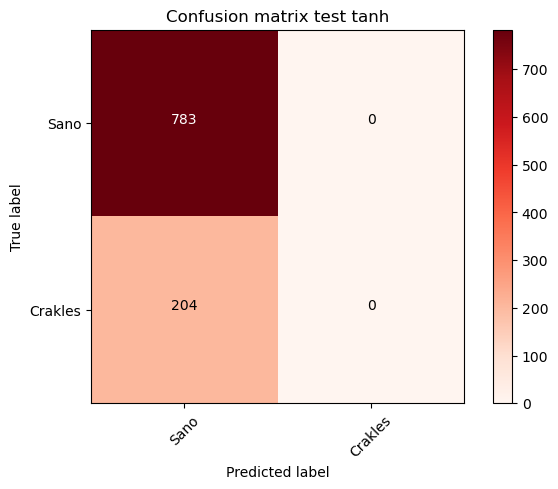

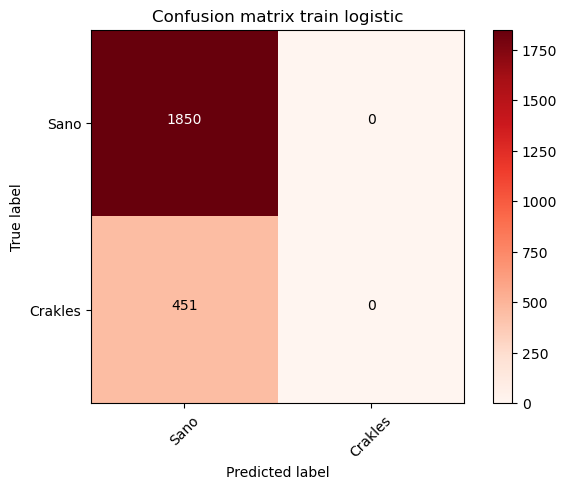

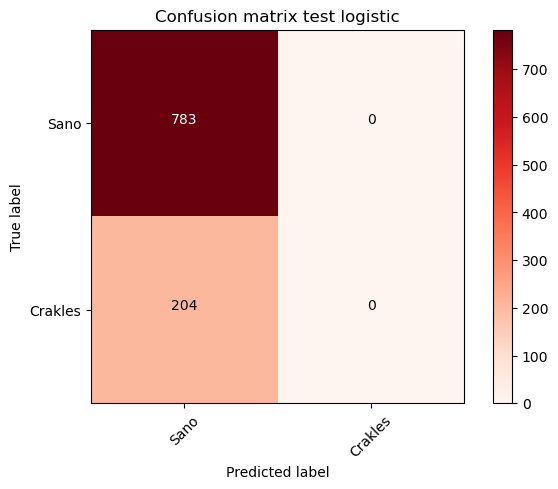

In [20]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Crakles'])

## Lo que no se pidió

Train  tanh
------------
Square error: 0.3475201072386059
              precision    recall  f1-score   support

           0       0.55      0.41      0.47      1120
           1       0.69      0.80      0.74      1864

    accuracy                           0.65      2984
   macro avg       0.62      0.60      0.60      2984
weighted avg       0.64      0.65      0.64      2984

Confusion matrix, without normalization
[[ 456  664]
 [ 373 1491]]
------------
Test  tanh
Square error: 0.36484375
              precision    recall  f1-score   support

           0       0.56      0.40      0.47       511
           1       0.66      0.79      0.72       769

    accuracy                           0.64      1280
   macro avg       0.61      0.60      0.59      1280
weighted avg       0.62      0.64      0.62      1280

Confusion matrix, without normalization
[[204 307]
 [160 609]]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes

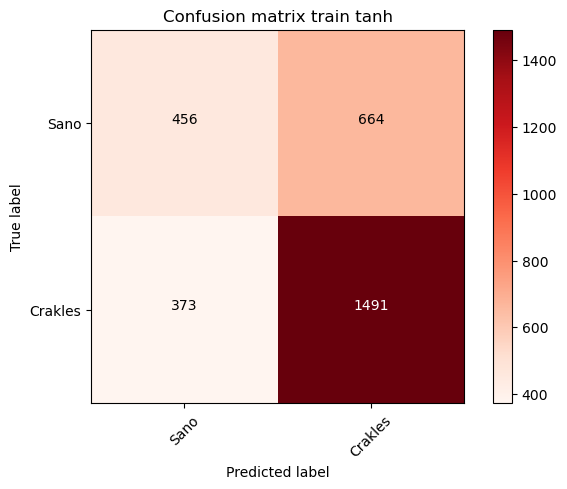

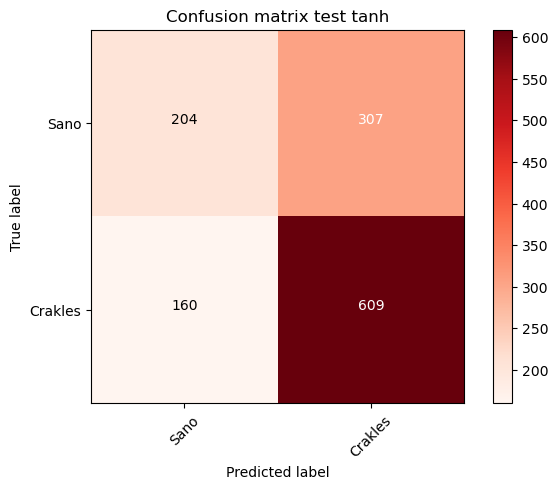

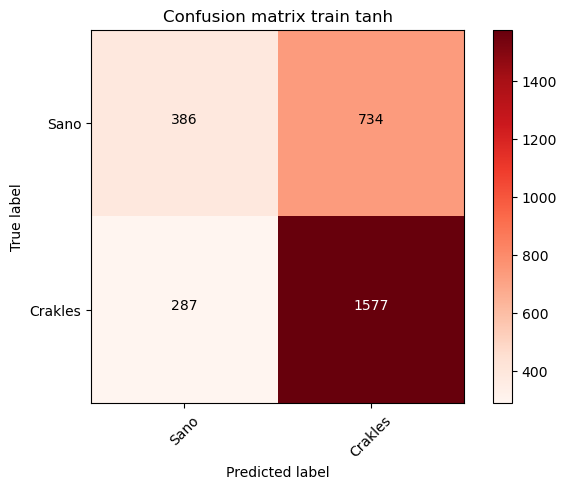

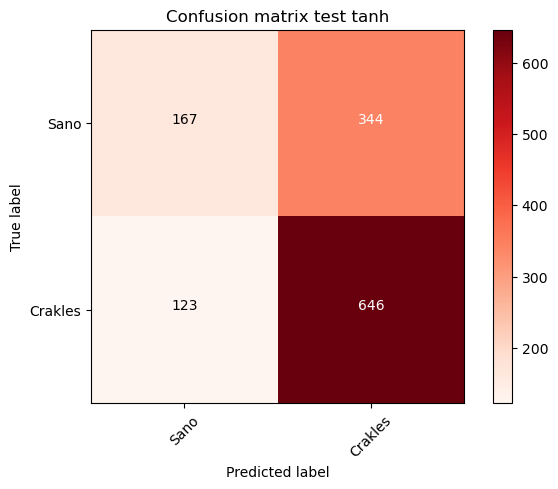

In [17]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Crakles'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
start=sem-2
end=sem
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring='f1')
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Crakles'])

Pero que parámetros son mejores:

# 2. Ciclos normales y ciclos silbantes

## Lo que pide el trabajo:

(3288, 3) (3288,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2301, 3) (987, 3)
Train  relu
------------
Square error: 0.19295958279009126
              precision    recall  f1-score   support

           1       0.81      1.00      0.89      1857
           2       0.00      0.00      0.00       444

    accuracy                           0.81      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.81      0.72      2301

Confusion matrix, without normalization
[[1857    0]
 [ 444    0]]
------------
Test  relu
Square error: 0.2137791286727457
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       776
           2       0.00      0.00      0.00       211

    accuracy                           0.79       987
   macro avg       0.39      0.50      0.44       987
weighted avg       0.62      0.79      0.69       987

Confusion matrix, without normalization
[[776   0]
 [211   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
Square error: 0.19295958279009126
              precision    recall  f1-score   support

           1       0.81      1.00      0.89      1857
           2       0.00      0.00      0.00       444

    accuracy                           0.81      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.81      0.72      2301

Confusion matrix, without normalization
[[1857    0]
 [ 444    0]]
------------
Test  identity
Square error: 0.2137791286727457
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       776
           2       0.00      0.00      0.00       211

    accuracy                           0.79       987
   macro avg       0.39      0.50      0.44       987
weighted avg       0.62      0.79      0.69       987

Confusion matrix, without normalization
[[776   0]
 [211   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
Square error: 0.19295958279009126
              precision    recall  f1-score   support

           1       0.81      1.00      0.89      1857
           2       0.00      0.00      0.00       444

    accuracy                           0.81      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.81      0.72      2301

Confusion matrix, without normalization
[[1857    0]
 [ 444    0]]
------------
Test  tanh
Square error: 0.2137791286727457
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       776
           2       0.00      0.00      0.00       211

    accuracy                           0.79       987
   macro avg       0.39      0.50      0.44       987
weighted avg       0.62      0.79      0.69       987

Confusion matrix, without normalization
[[776   0]
 [211   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
Square error: 0.19295958279009126
              precision    recall  f1-score   support

           1       0.81      1.00      0.89      1857
           2       0.00      0.00      0.00       444

    accuracy                           0.81      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.81      0.72      2301

Confusion matrix, without normalization
[[1857    0]
 [ 444    0]]
------------
Test  logistic
Square error: 0.2137791286727457
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       776
           2       0.00      0.00      0.00       211

    accuracy                           0.79       987
   macro avg       0.39      0.50      0.44       987
weighted avg       0.62      0.79      0.69       987

Confusion matrix, without normalization
[[776   0]
 [211   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

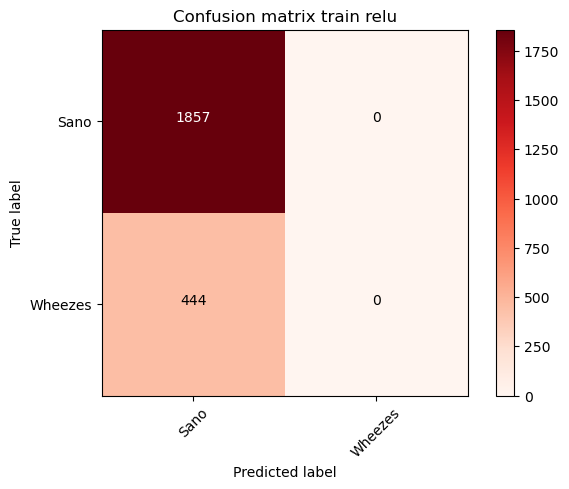

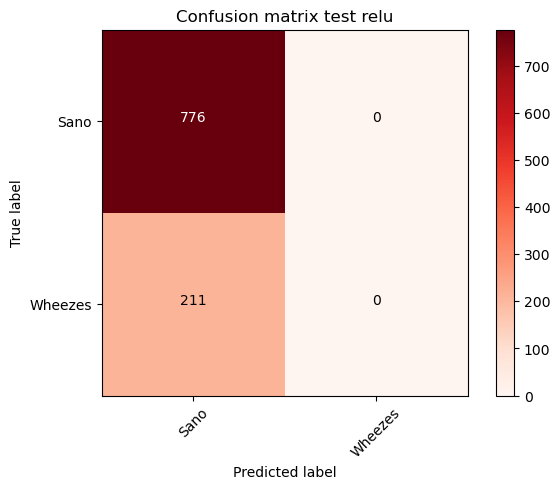

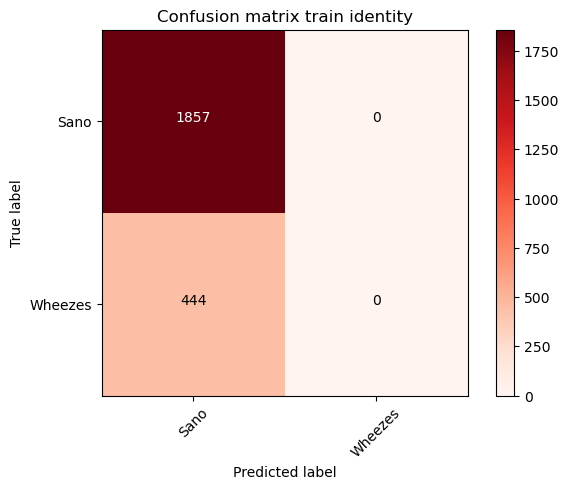

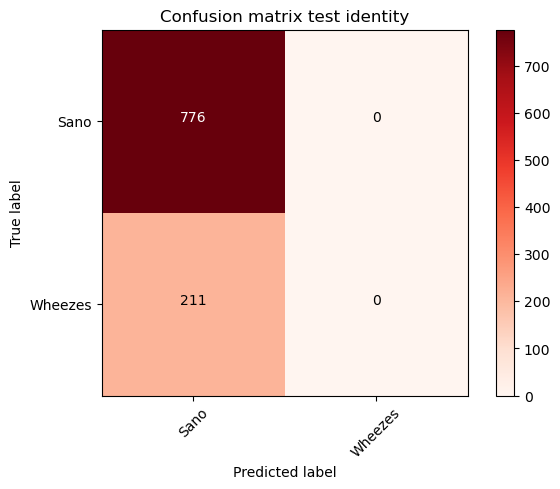

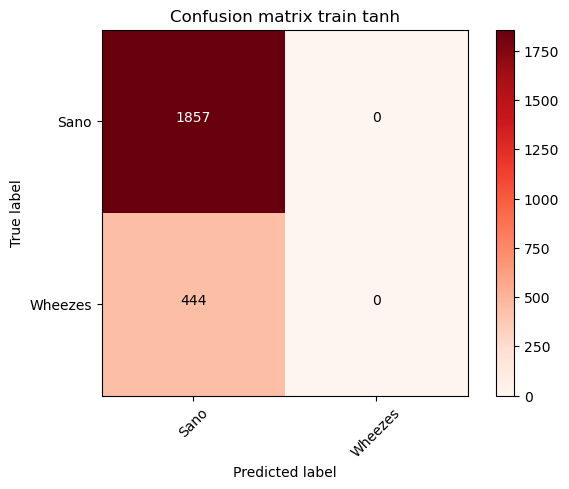

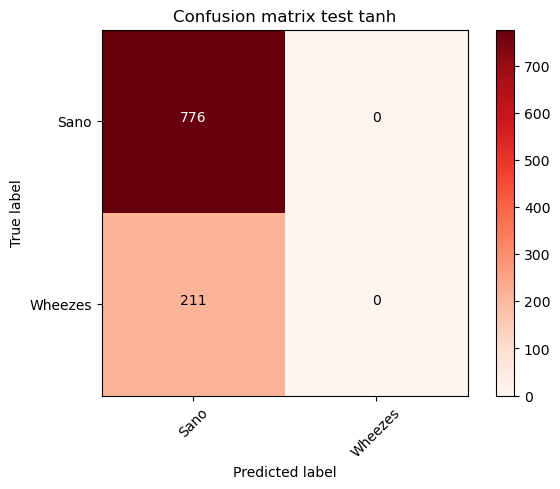

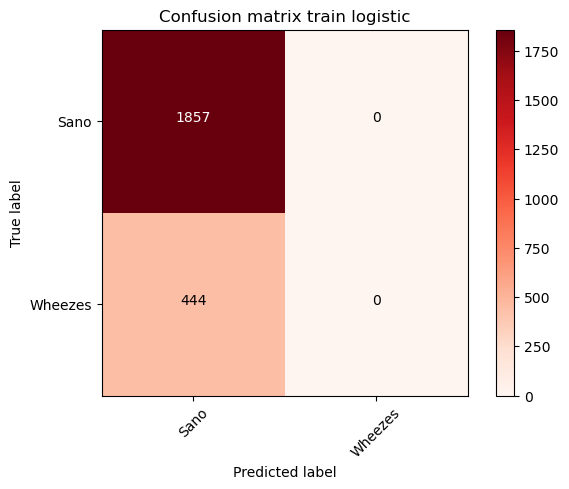

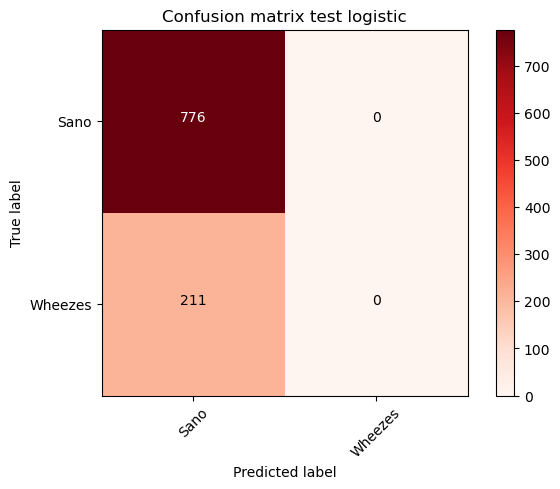

In [22]:
con=(d2.Estado.values==1)|(d2.Estado.values==2)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## La optimización porque no voy a perder lo que estudie en IA

Train  relu
------------
Square error: 0.19295958279009126
              precision    recall  f1-score   support

           1       0.81      1.00      0.89      1857
           2       0.00      0.00      0.00       444

    accuracy                           0.81      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.81      0.72      2301

Confusion matrix, without normalization
[[1857    0]
 [ 444    0]]
------------
Test  relu
Square error: 0.2137791286727457
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       776
           2       0.00      0.00      0.00       211

    accuracy                           0.79       987
   macro avg       0.39      0.50      0.44       987
weighted avg       0.62      0.79      0.69       987

Confusion matrix, without normalization
[[776   0]
 [211   0]]
MLPClassifier(hidden_layer_sizes=(1, 1, 1), max_iter=10000)
Fitting 5 folds for each of 27 candidate

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

[CV] END .......................hidden_layer_sizes=(1, 1, 0); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 0); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.8s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.8s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.4s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.3s
Best Parameters: {'hidden_layer_sizes': (1, 1, 1)}
Best Score: 0.8932176786293524


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
130 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 430, in _fit
    raise ValueError

Train  relu
------------
Square error: 0.19295958279009126
              precision    recall  f1-score   support

           1       0.81      1.00      0.89      1857
           2       0.00      0.00      0.00       444

    accuracy                           0.81      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.81      0.72      2301

Confusion matrix, without normalization
[[1857    0]
 [ 444    0]]
------------
Test  relu
Square error: 0.2137791286727457
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       776
           2       0.00      0.00      0.00       211

    accuracy                           0.79       987
   macro avg       0.39      0.50      0.44       987
weighted avg       0.62      0.79      0.69       987

Confusion matrix, without normalization
[[776   0]
 [211   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

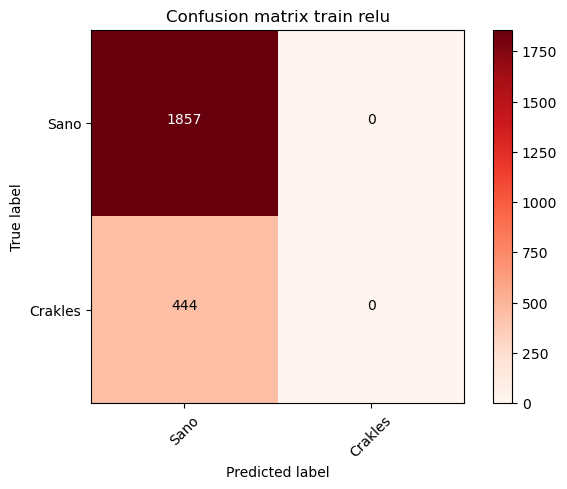

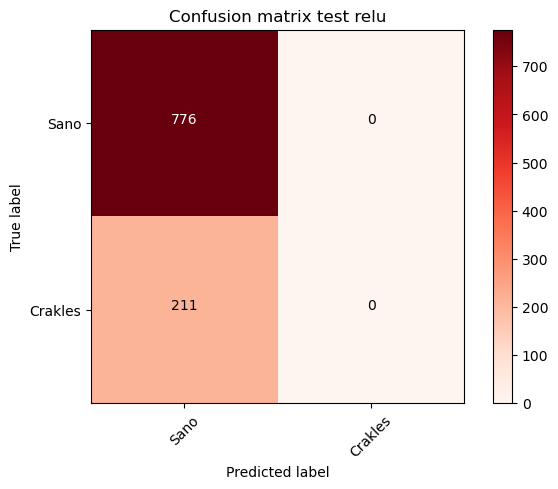

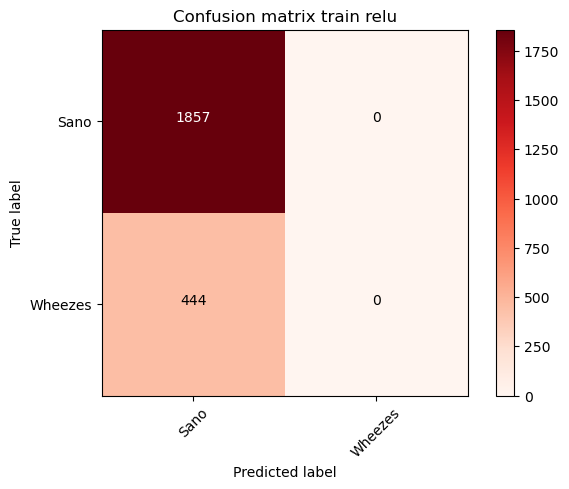

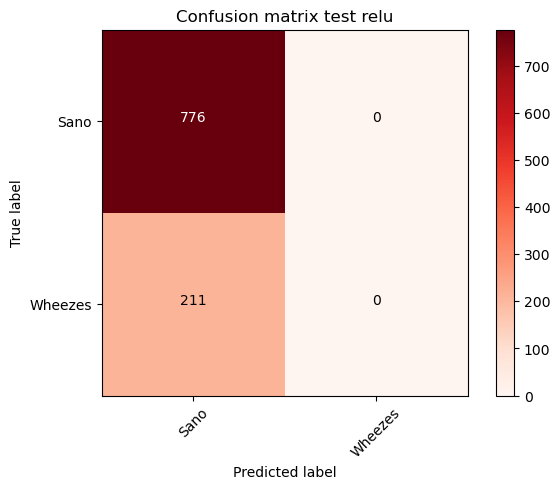

In [23]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Wheezes'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
start=sem-2
end=sem
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring='f1')
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## 3. Silibantes y crepitantes

## Lo que si 

(2286, 3) (2286,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1600, 3) (686, 3)
Train  relu
------------
Square error: 1.1625
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      1132
           2       0.57      0.03      0.05       468

    accuracy                           0.71      1600
   macro avg       0.64      0.51      0.44      1600
weighted avg       0.67      0.71      0.60      1600

Confusion matrix, without normalization
[[1122   10]
 [ 455   13]]
------------
Test  relu
Square error: 1.0787172011661808
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       499
           2       0.75      0.02      0.03       187

    accuracy                           0.73       686
   macro avg       0.74      0.51      0.44       686
weighted avg       0.74      0.73      0.62       686

Confusion matrix, without normalization
[[498   1]
 [184   3]]
Train  identity
--------

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1132
           2       0.00      0.00      0.00       468

    accuracy                           0.71      1600
   macro avg       0.35      0.50      0.41      1600
weighted avg       0.50      0.71      0.59      1600

Confusion matrix, without normalization
[[1132    0]
 [ 468    0]]
------------
Test  tanh
Square error: 1.0903790087463556
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       499
           2       0.00      0.00      0.00       187

    accuracy                           0.73       686
   macro avg       0.36      0.50      0.42       686
weighted avg       0.53      0.73      0.61       686

Confusion matrix, without normalization
[[499   0]
 [187   0]]
Train  logistic
------------
Square error: 1.17
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1132
  

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


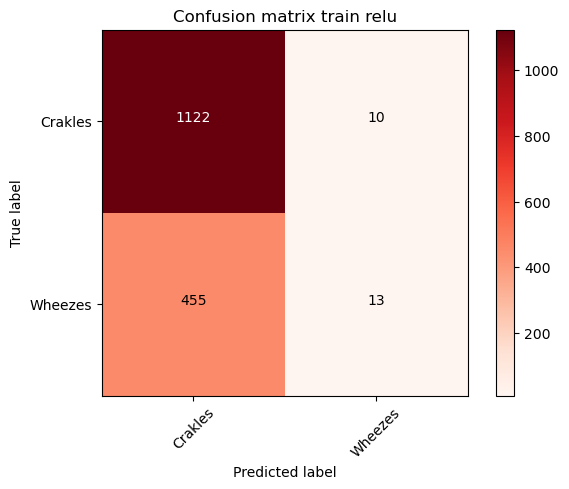

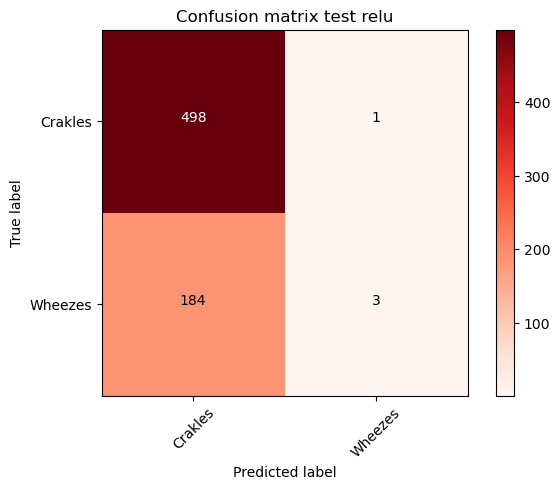

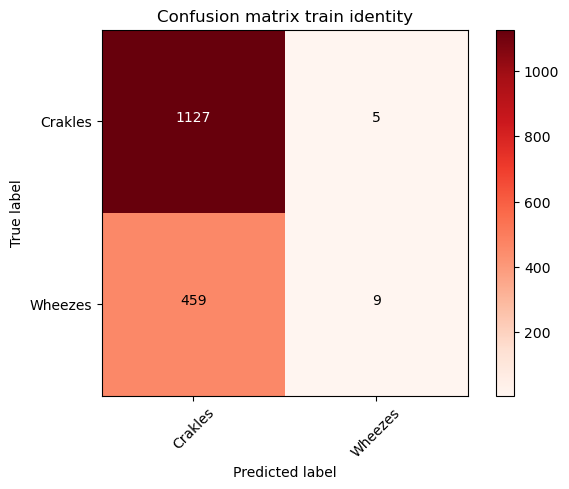

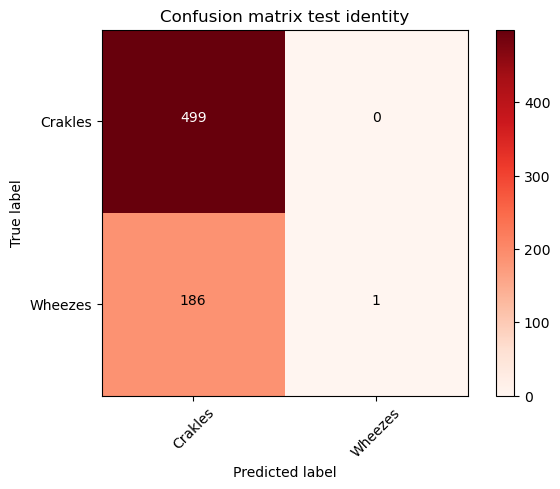

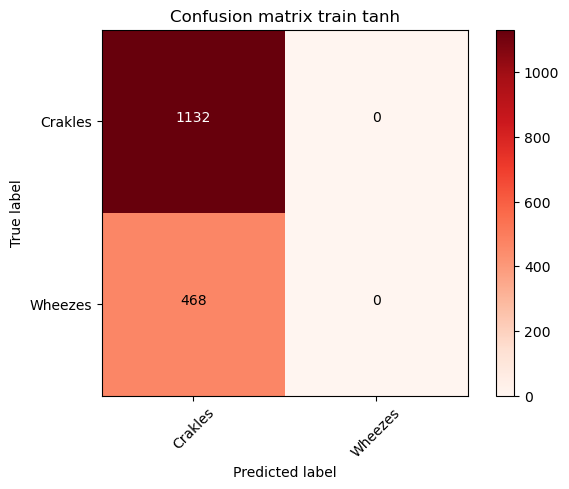

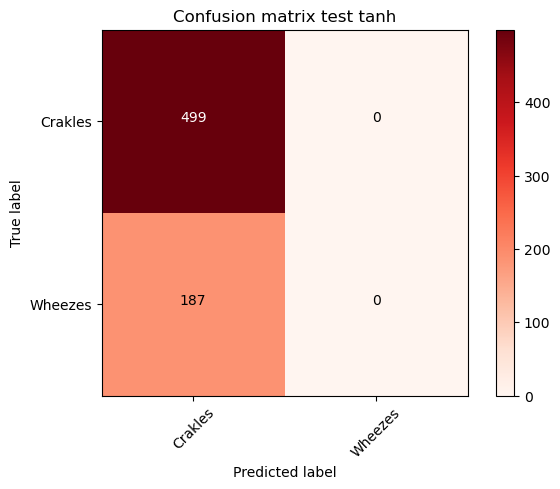

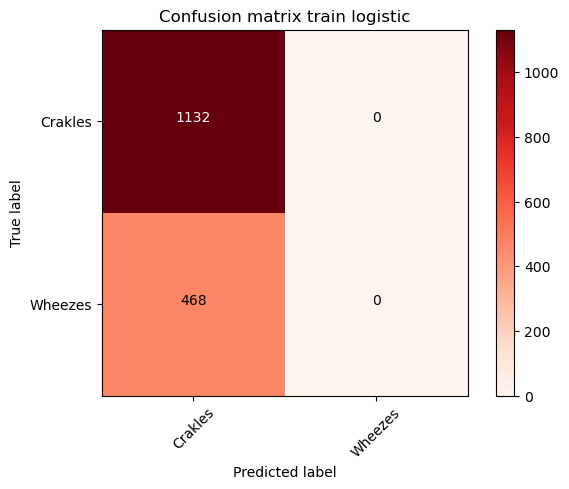

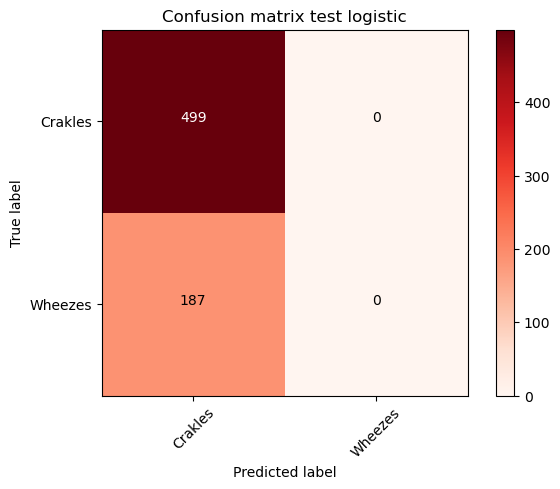

In [24]:
con=(d2.Estado.values==0)|(d2.Estado.values==2)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

## Lo que espero que nos den más nota:

Train  relu
------------
Square error: 1.1475
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      1132
           2       0.67      0.04      0.07       468

    accuracy                           0.71      1600
   macro avg       0.69      0.52      0.45      1600
weighted avg       0.70      0.71      0.61      1600

Confusion matrix, without normalization
[[1123    9]
 [ 450   18]]
------------
Test  relu
Square error: 1.0845481049562682
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       499
           2       0.56      0.03      0.05       187

    accuracy                           0.73       686
   macro avg       0.64      0.51      0.45       686
weighted avg       0.68      0.73      0.63       686

Confusion matrix, without normalization
[[495   4]
 [182   5]]
MLPClassifier(hidden_layer_sizes=(19, 19, 19), max_iter=10000)
Fitting 5 folds for each of 27 candidates, totalli

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 17); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(17, 17, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(17, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 17); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(17, 17, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(17, 17, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 18); total time=   0.3s
[CV] END ....................hidden_layer_sizes=(17, 17, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 18); total time=   0.7s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 19); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(17, 17, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 19); total time=   0.5s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 17, 19); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(17, 18, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(17, 18, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 17); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(17, 18, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 17); total time=   0.6s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 18); total time=   1.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 18); total time=   0.5s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 18); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(17, 18, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 18); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(17, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(17, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 18, 19); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(17, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 17); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(17, 19, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 17); total time=   0.5s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 17); total time=   0.7s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 17); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(17, 19, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(17, 19, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(17, 19, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 18); total time=   1.0s
[CV] END ....................hidden_layer_sizes=(17, 19, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 19); total time=   0.1s
[CV] END ....................hidden_layer_sizes=(17, 19, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 19); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(17, 19, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(17, 19, 19); total time=   0.6s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 17); total time=   0.5s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 17); total time=   0.1s
[CV] END ....................hidden_layer_sizes=(18, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 17); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(18, 17, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 17, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 18); total time=   0.4s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 18); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(18, 17, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 17, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 19); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(18, 17, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 17, 19); total time=   0.6s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 17); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(18, 18, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 17); total time=   0.3s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 17); total time=   0.2s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 17); total time=   0.6s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   1.0s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   1.1s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 19, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 19, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 17); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(18, 19, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 19, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 18); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(18, 19, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 19, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 18); total time=   0.7s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 18); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(18, 19, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 19, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 19); total time=   0.4s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(18, 19, 19); total time=   0.3s
[CV] END ....................hidden_layer_sizes=(19, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 17); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(19, 17, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 18); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(19, 17, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 18); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(19, 17, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 17, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 19); total time=   0.5s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 19); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(19, 17, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 17, 19); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(19, 17, 19); total time=   0.1s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 18, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 17); total time=   0.5s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 17); total time=   0.7s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 17); total time=   0.4s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 18); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(19, 18, 18); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 18, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 18); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(19, 18, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 18, 19); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(19, 18, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 18, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 17); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 19, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 17); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(19, 19, 17); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 17); total time=   0.3s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 18); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(19, 19, 18); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 18); total time=   0.7s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 18); total time=   0.4s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 18); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(19, 19, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 19, 19); total time=   0.0s


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_suppo

[CV] END ....................hidden_layer_sizes=(19, 19, 19); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(19, 19, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(19, 19, 19); total time=   0.0s
Best Parameters: {'hidden_layer_sizes': (17, 17, 17)}
Best Score: nan
Train  relu
------------
Square error: 1.1525
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      1132
           2       0.62      0.04      0.07       468

    accuracy                           0.71      1600
   macro avg       0.67      0.51      0.45      1600
weighted avg       0.69      0.71      0.61      1600

Confusion matrix, without normalization
[[1121   11]
 [ 450   18]]
------------
Test  relu
Square error: 1.0670553935860059
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       499
           2       0.75      0.03      0.06       187

    accuracy              

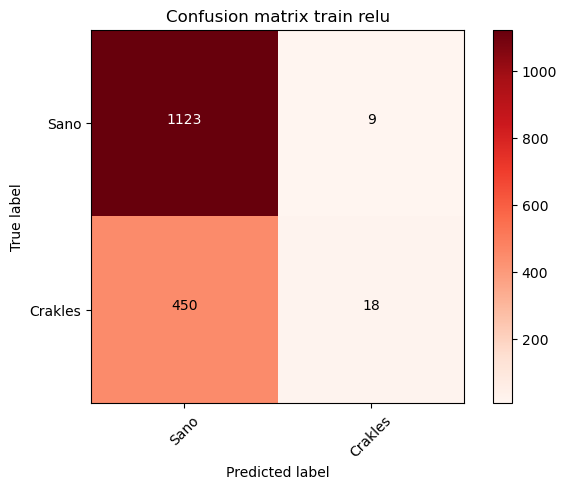

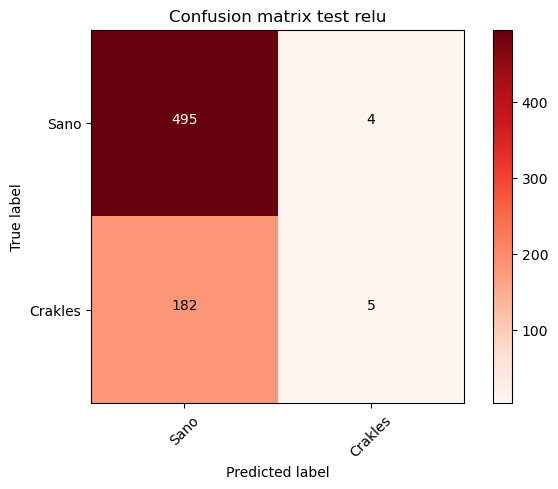

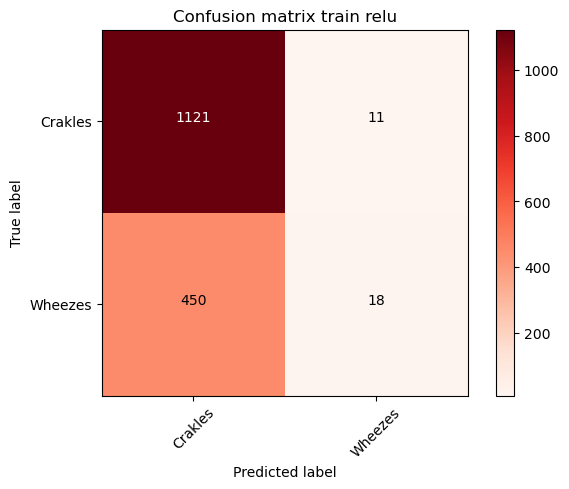

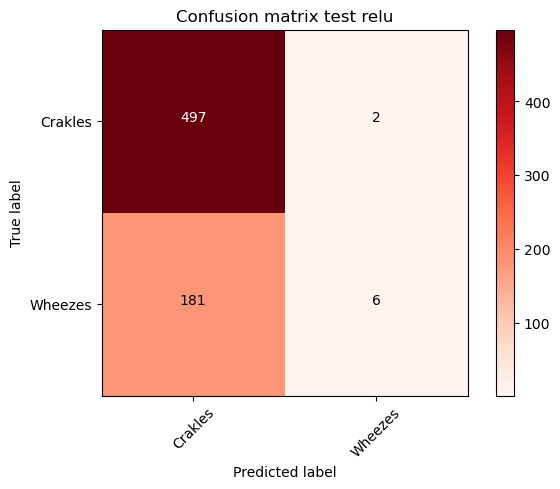

In [25]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
start=sem-2
end=sem
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring='f1')
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

# 4. Normales, silibantes y crepitantes

## Franklin perdón si llegas hasta aquí

(4919, 3) (4919,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(3443, 3) (1476, 3)
Train  relu
------------
Square error: 0.5582340981702004
              precision    recall  f1-score   support

           0       0.50      0.46      0.48      1167
           1       0.60      0.78      0.68      1813
           2       0.00      0.00      0.00       463

    accuracy                           0.57      3443
   macro avg       0.37      0.41      0.38      3443
weighted avg       0.48      0.57      0.52      3443

Confusion matrix, without normalization
[[ 536  631    0]
 [ 399 1414    0]
 [ 143  320    0]]
------------
Test  relu
Square error: 0.5650406504065041
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       464
           1       0.60      0.75      0.67       820
           2       0.00      0.00      0.00       192

    accuracy                           0.55      1476
   macro avg       0.34      0.39      0.36    

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
Square error: 0.4766192274179495
              precision    recall  f1-score   support

           0       0.59      0.05      0.09      1167
           1       0.53      0.99      0.69      1813
           2       0.00      0.00      0.00       463

    accuracy                           0.54      3443
   macro avg       0.37      0.34      0.26      3443
weighted avg       0.48      0.54      0.40      3443

Confusion matrix, without normalization
[[  58 1109    0]
 [  27 1786    0]
 [  14  449    0]]
------------
Test  identity
Square error: 0.43902439024390244
              precision    recall  f1-score   support

           0       0.64      0.06      0.11       464
           1       0.56      0.98      0.72       820
           2       0.00      0.00      0.00       192

    accuracy                           0.57      1476
   macro avg       0.40      0.35      0.27      1476
weighted avg       0.51      0.57      0.43      1476

Confusion matrix, w

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
Square error: 0.5736276503049667
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      1167
           1       0.61      0.76      0.67      1813
           2       0.00      0.00      0.00       463

    accuracy                           0.57      3443
   macro avg       0.37      0.42      0.39      3443
weighted avg       0.49      0.57      0.52      3443

Confusion matrix, without normalization
[[ 581  586    0]
 [ 443 1370    0]
 [ 161  302    0]]
------------
Test  tanh
Square error: 0.5691056910569106
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       464
           1       0.60      0.73      0.66       820
           2       0.00      0.00      0.00       192

    accuracy                           0.54      1476
   macro avg       0.34      0.39      0.37      1476
weighted avg       0.47      0.54      0.50      1476

Confusion matrix, without no

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
Square error: 0.4734243392390357
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1167
           1       0.53      1.00      0.69      1813
           2       0.00      0.00      0.00       463

    accuracy                           0.53      3443
   macro avg       0.18      0.33      0.23      3443
weighted avg       0.28      0.53      0.36      3443

Confusion matrix, without normalization
[[   0 1167    0]
 [   0 1813    0]
 [   0  463    0]]
------------
Test  logistic
Square error: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       464
           1       0.56      1.00      0.71       820
           2       0.00      0.00      0.00       192

    accuracy                           0.56      1476
   macro avg       0.19      0.33      0.24      1476
weighted avg       0.31      0.56      0.40      1476

Confusion matrix, wi

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

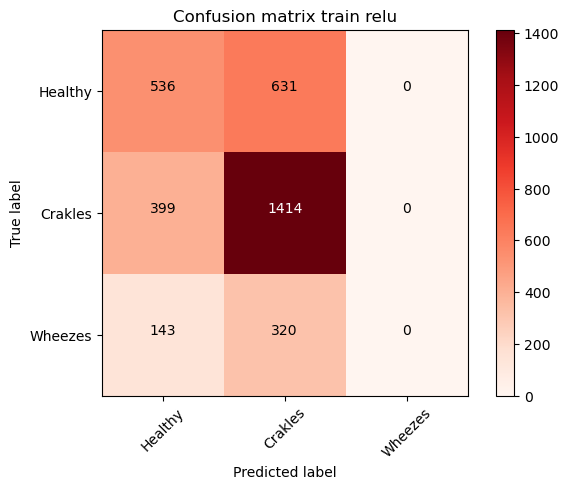

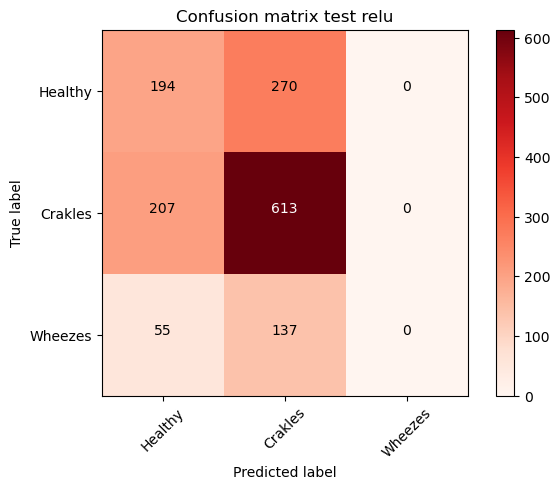

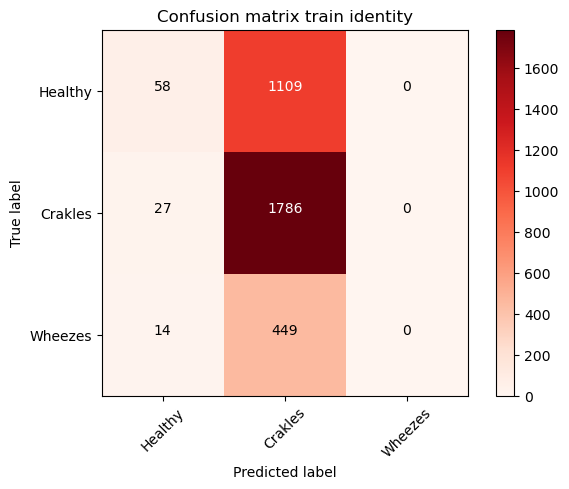

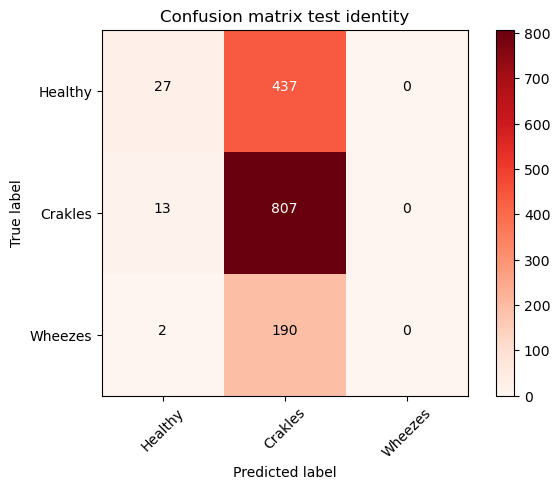

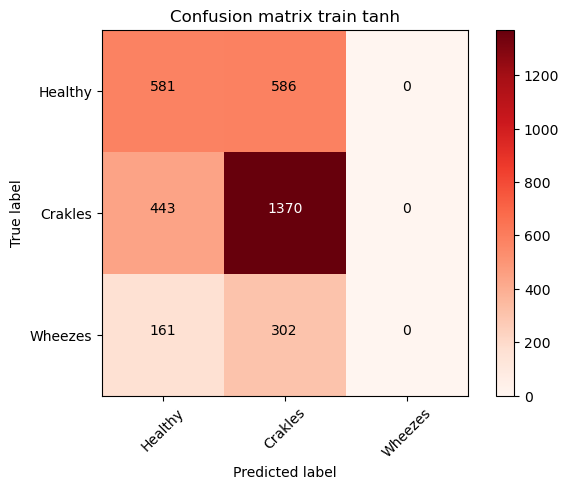

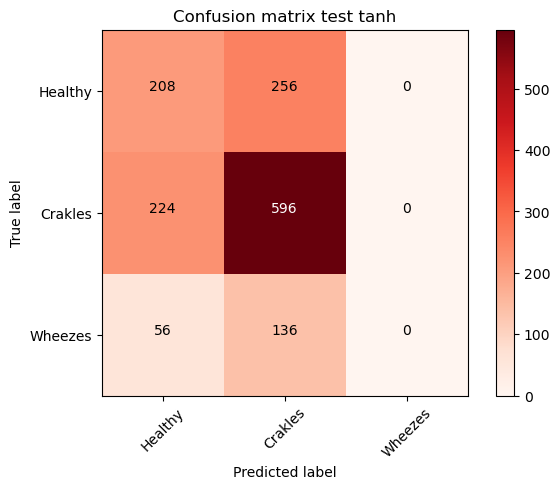

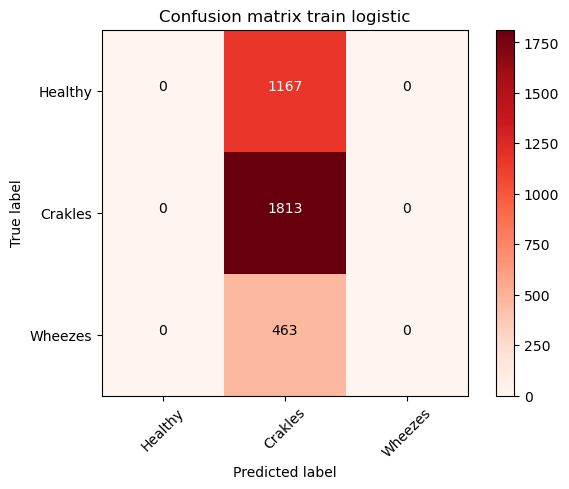

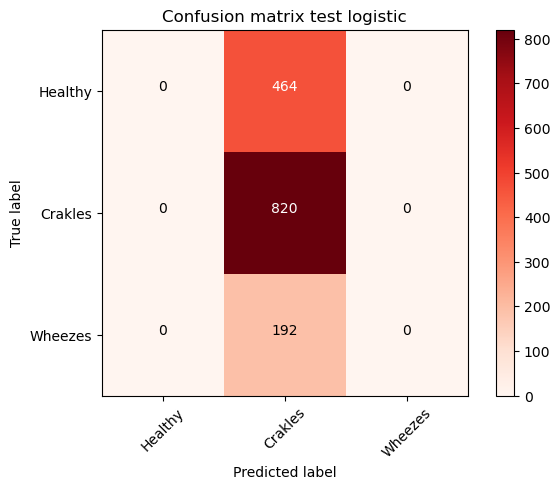

In [26]:
x=d2.drop(["Estado"],axis=1)
y=d2.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])

## Dormir esta sobrevalorado 

In [27]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
start=sem-2
end=sem
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss") #En este caso cambiamos f1 ya que al ser multiples variables
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])